In [1]:
# importing some necessary libraries
import os

import warnings  
warnings.filterwarnings('ignore')

# importing packages for reading data and for visualization
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn packages for checking accuracy and for extracting important features
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [2]:
# nltk packages to remove unncessary words
import nltk
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm
from nltk.corpus import stopwords
stopwordEn = stopwords.words('english')
from nltk.corpus import wordnet
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

In [3]:
# reading the tsv file
df = pd.read_csv("train_data_for_students.tsv",sep='\t')
df_test = pd.read_csv('test_data.tsv',sep='\t')
# displaying first few rows of our data
df.head()

,845974102619906048,realDonaldTrump,"Democrats are smiling in D.C. that the Freedom Caucus, with the help of Club For Growth and Heritage, have saved Planned Parenthood &amp; Ocare!",2017-03-26 15:21:58,iphone
0,846166053663191040,realDonaldTrump,General Kelly is doing a great job at the bord...,2017-03-27 04:04:42,iphone
1,835814988686233601,realDonaldTrump,"The race for DNC Chairman was, of course, tota...",2017-02-26 13:33:16,android
2,835817351178301440,realDonaldTrump,For first time the failing @nytimes will take ...,2017-02-26 13:42:39,android
3,835916511944523777,realDonaldTrump,"Russia talk is FAKE NEWS put out by the Dems, ...",2017-02-26 20:16:41,android
4,835946001873657858,realDonaldTrump,Big dinner with Governors tonight at White Hou...,2017-02-26 22:13:52,android


In [4]:
df_test.head()

,768083669550366720,realDonaldTrump,"It is being reported by virtually everyone, and is a fact, that the media pile on against me is the worst in American political history!",2016-08-23 16:53:11
0,768097204376510464,realDonaldTrump,Hillary Clinton strongly stated that there wa...,2016-08-23 17:46:58
1,768119463421943808,realDonaldTrump,President Obama should have gone to Louisiana ...,2016-08-23 19:15:25
2,768125054584393729,realDonaldTrump,"Join me in Tampa, Florida- tomorrow at 1pmE! T...",2016-08-23 19:37:38
3,768196613680398336,realDonaldTrump,"In Austin, Texas with some of our amazing Bord...",2016-08-24 00:21:59
4,768239855310471168,realDonaldTrump,Will be participating in a Town Hall tonight o...,2016-08-24 03:13:49


2. Data preprocessing

We do not performa detailed feature analysis of the data, since we have a clear objective,
using tweets and iphone to determine twitter types

2.1 Selecting features
First we drop some of the columns we are certainly not interested in. The ones not droped will be helpful to clean the data.

In [5]:
# dropping unncessary columns
df = df.drop(['845974102619906048', 'realDonaldTrump','2017-03-26 15:21:58'], axis = 1)
# dropping unncessary columns
df_test = df_test.drop(['768083669550366720', 'realDonaldTrump','2016-08-23 16:53:11'], axis = 1)

In [6]:
#displaying first five rows of data
df.head()

,"Democrats are smiling in D.C. that the Freedom Caucus, with the help of Club For Growth and Heritage, have saved Planned Parenthood &amp; Ocare!",iphone
0,General Kelly is doing a great job at the bord...,iphone
1,"The race for DNC Chairman was, of course, tota...",android
2,For first time the failing @nytimes will take ...,android
3,"Russia talk is FAKE NEWS put out by the Dems, ...",android
4,Big dinner with Governors tonight at White Hou...,android


In [7]:
# again checking the shape
df.shape

(2681, 2)

2.2 Removing duplicates, NAs and text formatting
We do not want any duplication in the description column since that might falsely over emphasize certain features. 
Therefore, we start by dropping any tweets duplicates.

In [8]:
# first renameing our columns names with tweetes and phone
df = df.rename(columns={
    'Democrats are smiling in D.C. that the Freedom Caucus, with the help of Club For Growth and Heritage, have saved Planned Parenthood &amp; Ocare!':'tweets',
    'iphone':'phone'
})

In [9]:
df_test.columns

Index(['It is being reported by virtually everyone, and is a fact,  that the media pile on against me is the worst in American political history!'], dtype='object')

In [10]:
# first renameing our columns names with tweetes and phone
df_test = df_test.rename(columns={
    'It is being reported by virtually everyone, and is a fact,  that the media pile on against me is the worst in American political history!':'tweets'
})

In [11]:
# #displaying first five rows of data
df.head()

,tweets,phone
0,General Kelly is doing a great job at the bord...,iphone
1,"The race for DNC Chairman was, of course, tota...",android
2,For first time the failing @nytimes will take ...,android
3,"Russia talk is FAKE NEWS put out by the Dems, ...",android
4,Big dinner with Governors tonight at White Hou...,android


In [12]:
df_test.head()

,tweets
0,Hillary Clinton strongly stated that there wa...
1,President Obama should have gone to Louisiana ...
2,"Join me in Tampa, Florida- tomorrow at 1pmE! T..."
3,"In Austin, Texas with some of our amazing Bord..."
4,Will be participating in a Town Hall tonight o...


In [13]:
# dropping the duplicates values from tweets
df = df.drop_duplicates('tweets')
df_test = df_test.drop_duplicates('tweets')

In [14]:
# after dropping duplicates now checking the shape again
df.shape

(2675, 2)

Interestingly there were quite a few duplicates. There were either duplicates of some tweets. Now we have 2675 unique samples. Most of the times, these kind of data bases are not fully filled, therefore we might have some NAs in features we are interested in: tweets, phone. In the case of date we could estimate a value based on other similar inputs, but we are not able to come up with new tweets or phone, therefore we just simply drop any row that contains NAs in these columns.

In [15]:
# dropping the Nan values
df = df.dropna(subset=['tweets','phone'])
df_test = df_test.dropna(subset=['tweets'])

In [16]:
# now our final shape of data after performing preprocessing
df.shape

(2664, 2)

In [17]:
# now our final shape of data after performing preprocessing
df_test.shape

(864, 1)

In [18]:
# dispalying first five rows of data
df.head()

,tweets,phone
0,General Kelly is doing a great job at the bord...,iphone
1,"The race for DNC Chairman was, of course, tota...",android
2,For first time the failing @nytimes will take ...,android
3,"Russia talk is FAKE NEWS put out by the Dems, ...",android
4,Big dinner with Governors tonight at White Hou...,android


In [19]:
# descriptive analysis of our data
df.describe(include='all')

,tweets,phone
count,2664,2664
unique,2664,9
top,General Kelly is doing a great job at the bord...,android
freq,1,1679


In [20]:
#filter now filter our phone in betweeen two categories between android and iphone
df['phone']=df.iloc[:,1:2][(df['phone']=='android') | (df['phone']=='iphone')]

In [21]:
# value counts for phone to check our final categories of columns
df['phone'].value_counts() 

android    1679
iphone      753
Name: phone, dtype: int64

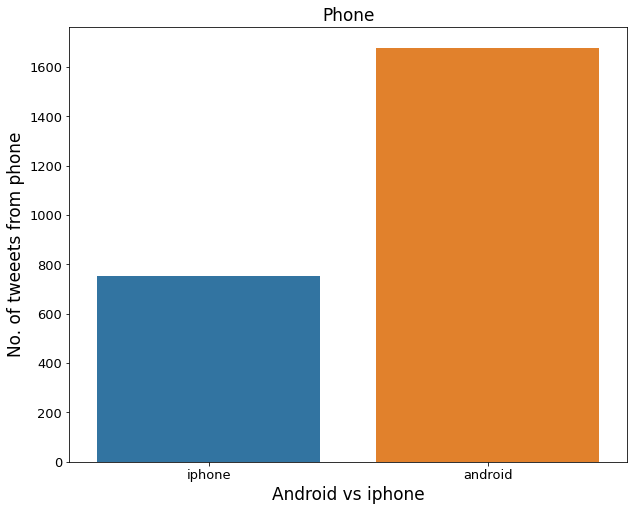

In [22]:
# checking the phone android vs iphone
plt.figure(figsize=(10,8))
ax=sns.countplot(df['phone'])
ax.set_xlabel(xlabel="Android vs iphone",fontsize=17)
ax.set_ylabel(ylabel='No. of tweeets from phone',fontsize=17)
ax.axes.set_title('Phone',fontsize=17)
ax.tick_params(labelsize=13)

In [23]:
# dropping nan values
df_test.dropna(inplace=True)
# dropping nan values
df.dropna(inplace=True)
# Renaming, Input -> X, Output -> y
X = df['tweets']
y = df['phone']
# Split into Training and Test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=df['phone'])
X_train = X
y_train = y
X_test = df_test

In [24]:
# checking the shape of X tarin and Y_tarin
print(X_train.shape)
print(y_train.shape)

(2432,)
(2432,)


In [25]:
# Performing lemmatization on word and steeming on word and also performing preprocssing, taging the workds
def lemmaWord(word):
    lemma = wordnet.morphy(word)
    if lemma is not None:
        return lemma
    else:
        return word

def stemWord(word):
    stem = stemmer.stem(word)
    if stem is not None:
        return stem
    else:
        return word

def processText(text,lemma=False, gram=1, rmStop=True): # default remove stop words
    for i in range(len(text)):
        text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b|@\w+|#', '', text, flags=re.MULTILINE) #delete URL, #hashtag# , and @xxx
        tokens = word_tokenize(text)
        whitelist = ["n't", "not", "no"]
        new_tokens = []
        stoplist = stopwordEn if rmStop else []
        for i in tokens:
            i = i.lower()
            if i.isalpha() and (i not in stoplist or i in whitelist):  #i not in ['.',',',';']  and (...)
                if lemma: i = lemmaWord(i)
                new_tokens.append(i)
        del tokens
    
        if gram<=1:
            return new_tokens
        else:
            return [' '.join(i) for i in nltk.ngrams(new_tokens, gram)]

def getTags(text):
    token = word_tokenize(text)
    token = [l.lower() for l in token]
    train_tags = nltk.pos_tag(token)
    return [i[1] for i in train_tags]

In [26]:
# lemmatization of words
for i in range(len(X_train)):
    print(lemmaWord(X_train.iloc[i]))

General Kelly is doing a great job at the border. Numbers are way down. Many are not even trying to come in anymore.
The race for DNC Chairman was, of course, totally "rigged." Bernie's guy, like Bernie himself, never had a chance. Clinton demanded Perez!
For first time the failing @nytimes will take an ad (a bad one) to help save its failing reputation. Try reporting accurately &amp; fairly!
Russia talk is FAKE NEWS put out by the Dems, and played up by the media, in order to mask the big election defeat and the illegal leaks!
Big dinner with Governors tonight at White House. Much to be discussed, including healthcare.
Congressman John Lewis should spend more time on fixing and helping his district, which is in horrible shape and falling apart (not to......
mention crime infested) rather than falsely complaining about the election results. All talk, talk, talk - no action or results. Sad!
INTELLIGENCE INSIDERS NOW CLAIM THE TRUMP DOSSIER IS "A COMPLETE FRAUD!"  @OANN
Congressman John 

The reporting at the failing @nytimes gets worse and worse by the day. Fortunately, it is a dying newspaper.
Thank you to everyone for all of the nice comments, by Twitter, pundits and otherwise for my speech last night.
Great job by @EricTrump on interview with @BillHemmer on @FoxNews. #ImWithYou #TrumpTrain
#WheresHillary? Sleeping!!!!!
We are one nation. When one hurts, we all hurt. We must all work together-to lift each other up. #StandWithLouisiana https://t.co/Ob7J2oBWhq
.@Franklin_Graham @BillyNungesser @SamaritansPurse- so humbled by my time w/ you. You are in our thoughts &amp; prayers. https://t.co/I6xGsEzlwv
My experience in Iowa was a great one. I started out with all of the experts saying I couldn't do well there and ended up in 2nd place. Nice
Because I was told I could not do well in Iowa, I spent very little there - a fraction of Cruz &amp; Rubio. Came in a strong second. Great honor
The media has not covered my long-shot great finish in Iowa fairly. Brought in record v

In [27]:
# stemming the words
for i in range(len(X_train)):
    print(stemWord(X_train.iloc[i]))

general kelly is doing a great job at the border. numbers are way down. many are not even trying to come in anymore.
the race for dnc chairman was, of course, totally "rigged." bernie's guy, like bernie himself, never had a chance. clinton demanded perez!
for first time the failing @nytimes will take an ad (a bad one) to help save its failing reputation. try reporting accurately &amp; fairly!
russia talk is fake news put out by the dems, and played up by the media, in order to mask the big election defeat and the illegal leaks!
big dinner with governors tonight at white house. much to be discussed, including healthcare.
congressman john lewis should spend more time on fixing and helping his district, which is in horrible shape and falling apart (not to......
mention crime infested) rather than falsely complaining about the election results. all talk, talk, talk - no action or results. sad!
intelligence insiders now claim the trump dossier is "a complete fraud!"  @oann
congressman john 

@ofccadjust: @realdonaldtrump @jaketapper @cnn dvr set!
muhammad ali is dead at 74! a truly great champion and a wonderful guy. he will be missed by all!
in bangladesh, hostages were immediately killed by isis terrorists if they were unable to cite a verse from the koran. 20 were killed!
the third mass attack (slaughter) in days by isis. 200 dead in baghdad, worst in many years. we do not have leadership that can stop this!
crooked hillary will never be able to handle the complexities and danger of isis - it will just go on forever. we need change!
happy 4th of july! #trump2016 #americafirst https://t.co/ndb3aqrlty https://t.co/yhhyqjwjw6
dishonest media is trying their absolute best to depict a star in a tweet as the star of david rather than a sheriff's star, or plain star!
senator tom cotton was great on meet the press yesterday. despite a totally one-sided interview by chuck todd, the end result was solid!
spent time with indiana governor mike pence and family yesterday. very impre

russia has never tried to use leverage over me. i have nothing to do with russia - no deals, no loans, no nothing!
i win an election easily, a great "movement" is verified, and crooked opponents try to belittle our victory with fake news. a sorry state!
intelligence agencies should never have allowed this fake news to "leak" into the public. one last shot at me.are we living in nazi germany?
we had a great news conference at trump tower today. a couple of fake news organizations were there but the people truly get what's going on
michigan, mississippi, idaho &amp; hawaii: get out to vote and join the movement today! video: https://t.co/fjw8ax7e8p https://t.co/zdbarevyac
thank you @erictrump! https://t.co/u1itlmcbac
@erictrump: wishing our father tremendous luck in michigan, mississippi, idaho &amp; hawaii today! amazing father! https://t.co/cypx4ec9w @q
sun sentinel says: rubio lacks the experience, work ethic and gravitas needed to be president. he has not earned your vote!
remember, 

@teed_chris: @loyal2trump2016 @trumpalabama  @foxnews look when you try to kill your mom,that's it for me ,no walking on wat
@freedoms411: @wakeuppeoplesos @mitchellvii  @cnn @abc @cbs it shouldn't be ignored, and i doubt it will be, carson will drop in polls.
@rm1792: @realdonaldtrump man, i love the where you spoke the truth about hillary. we have waited so long for someone to do this.
@kniala: @realdonaldtrump exactly. marco has no accomplishments.
@burgettn: @ab1132 @realdonaldtrump it's the only way we can make america great again.
@jimmygould07: only one man has the appeal, nerve, commitment, ideas, &amp; motivation. he's the icon, business tycoon, and lovable donaldtrump	2015-11-10 08:03:51	android
663992530967621632	realdonaldtrump	@breitbartnews: ratings were huge for @realdonaldtrump's appearance on saturday night live -&gt; https://t.co/wdqxrq36yf"
@todayshow: trump's #snl show delivered the biggest overnight ratings since early 2012: https://t.co/ja9tn6mgdt https://t.co/c27

In [28]:
# processText 
for i in range(len(X_train)):
    print(processText(X_train.iloc[i]))

['general', 'kelly', 'great', 'job', 'border', 'numbers', 'way', 'many', 'not', 'even', 'trying', 'come', 'anymore']
['race', 'dnc', 'chairman', 'course', 'totally', 'rigged', 'bernie', 'guy', 'like', 'bernie', 'never', 'chance', 'clinton', 'demanded', 'perez']
['first', 'time', 'failing', 'take', 'ad', 'bad', 'one', 'help', 'save', 'failing', 'reputation', 'try', 'reporting', 'accurately', 'amp', 'fairly']
['russia', 'talk', 'fake', 'news', 'put', 'dems', 'played', 'media', 'order', 'mask', 'big', 'election', 'defeat', 'illegal', 'leaks']
['big', 'dinner', 'governors', 'tonight', 'white', 'house', 'much', 'discussed', 'including', 'healthcare']
['congressman', 'john', 'lewis', 'spend', 'time', 'fixing', 'helping', 'district', 'horrible', 'shape', 'falling', 'apart', 'not']
['mention', 'crime', 'infested', 'rather', 'falsely', 'complaining', 'election', 'results', 'talk', 'talk', 'talk', 'no', 'action', 'results', 'sad']
['intelligence', 'insiders', 'claim', 'trump', 'dossier', 'comple

['trump', 'candidate', 'ever', 'excited', 'somethingspecialishappening']
['interviewed', 'good', 'morning', 'america', 'tomorrow', 'big', 'new', 'abc', 'poll', 'coming', 'hope', 'well']
['great', 'tonight', 'thank', 'nice', 'words']
['opponents', 'no', 'idea', 'dealing', 'sun', 'tzu', 'would', 'proud', 'tactical', 'genius', 'artofwar']
['donald', 'keep', 'fighting', 'hope', 'america', 'android', 'realdonaldtrump', 'establishment', 'try', 'want', 'keep', 'winning', 'not', 'stronger', 'people']
['looking', 'forward', 'meeting', 'rally', 'burlington', 'iowa', 'tomorrow', 'makeamericagreatagain', 'see']
['first', 'time', 'ever', 'vote', 'got', 'mine', 'want', 'make', 'america', 'great', 'fantastic']
['go', 'everyone', 'loves', 'donald', 'trump', 'bcuz', 'real', 'thing', 'not', 'politician']
['well', 'said', 'people', 'want', 'truth', 'people', 'want', 'make', 'america', 'great']
['never', 'loved', 'candidate', 'much', 'love', 'ca', 'wait', 'make', 'america', 'great', 'nice']
['much', 'bett

['clinton', 'betrayed', 'bernie', 'voters', 'kaine', 'supports', 'tpp', 'pocket', 'wall', 'street', 'backed', 'iraq', 'war']
['bernie', 'totally', 'given', 'fight', 'people', 'welcome', 'voters', 'want', 'better', 'future', 'workers']
['hard', 'believe', 'bernie', 'sanders', 'done', 'complete', 'fold', 'got', 'nothing', 'time', 'energy', 'money', 'joke']
['met', 'juan', 'williams', 'passing', 'asked', 'could', 'pictures', 'taken', 'said', 'fine', 'trashes', 'air']
['cory', 'booker', 'future', 'democratic', 'party', 'no', 'future', 'know', 'cory', 'knows']
['sad', 'watch', 'bernie', 'sanders', 'abandon', 'revolution', 'welcome', 'voters', 'want', 'fix', 'rigged', 'system', 'bring', 'back', 'jobs']
['elizabeth', 'warren', 'often', 'referred', 'pocahontas', 'misrepresented', 'spoke', 'glowingly', 'crooked', 'hillary', 'always', 'hated']
['bernie', 'sanders', 'totally', 'sold', 'crooked', 'hillary', 'clinton', 'work', 'energy', 'money', 'nothing', 'show', 'waste', 'time']
['sleepy', 'eyes'

['huma', 'abedin', 'top', 'aide', 'hillary', 'clinton', 'wife', 'perv', 'sleazebag', 'anthony', 'wiener', 'major', 'security', 'risk', 'collector', 'info']
['optimism', 'index', 'surges', 'since']
['business', 'optimism', 'soars', 'trump', 'election']
['helps', 'lift', 'small', 'business', 'confidence', 'high']
['fake', 'news', 'total', 'political', 'witch', 'hunt']
['rt', 'never', 'prague', 'life', 'fakenews']
['runs', 'unverifiable', 'claims', 'fakenews']
['thank', 'hawaii']
['phony', 'club', 'growth', 'tried', 'shake', 'one', 'millions', 'dollars', 'putting', 'nasty', 'negative', 'ads', 'total', 'losers']
['phony', 'club', 'growth', 'tried', 'shake', 'one', 'million', 'dollars', 'amp', 'putting', 'nasty', 'negative', 'ads', 'total', 'losers']
['keep', 'lightweight', 'marco', 'friends', 'white', 'house', 'makeamericagreatagain']
['another', 'dishonest', 'politician', 'lightweightsenatormarcorubio']
['giving', 'lengthy', 'interview', 'tonight', 'florida', 'watch', 'makeamericagreataga

['wow', 'fantastic', 'knew', 'americans', 'smart', 'great', 'know', 'smart']
['good', 'morning', 'trump', 'awesome']
['dying', 'newspaper', 'nh', 'turmoil', 'comments', 'like', 'bully', 'got', 'knocked']
['joe', 'mcquaid', 'desperately', 'trying', 'sell', 'loser', 'comments', 'helped', 'much']
['joe', 'mcquaid', 'desperately', 'trying', 'sell', 'loser', 'comments', 'helped', 'much']
['never', 'thought', 'saying', 'really', 'enjoyed', 'television', 'lately', 'terrific', 'hosting']
['thank', 'hilton', 'head', 'south', 'carolina']
['thank', 'hilton', 'head', 'south', 'carolina', 'makeamericagreatagain']
['going', 'live', 'ring', 'new', 'year', 'everybody', 'tune', 'tomorrow', 'night']
['great', 'thank', 'nevada', 'makeamericagreatagain']
['lovely', 'letter', 'daughter', 'late', 'great', 'john', 'wayne', 'country', 'could', 'use', 'john', 'wayne', 'right']
['predict', 'dying', 'newspaper', 'run', 'ground', 'publisher', 'stinky', 'joe', 'mcquaid', 'dead', 'years']
['great', 'day', 'south', 

['love', 'amp', 'real', 'men', 'opinion', 'exciting', 'interesting', 'controversial', 'android', 'realdonaldtrump', 'bashing', 'distinguished', 'women', 'journalists', 'wo', 'win', 'votes', 'rate', 'total', 'dummy']
['iran', 'money', 'else', 'given', 'obama', 'wanted', 'way', 'take', 'saudi', 'arabia', 'amp', 'oil', 'found']
['worst', 'thing', 'hillary', 'could', 'husband', 'campaign', 'watch']
['way', 'hillary', 'amp', 'msm', 'forgot', 'mention', 'hillary', 'terror', 'video']
['iowan', 'voting', 'iacaucus', 'thank', 'supporting', 'iowa', 'great', 'honor']
['let', 'go', 'pa', 'vote', 'go', 'trump']
['new', 'jersey', 'man', 'joseph', 'hornick', 'willing', 'go', 'jail', 'flying', 'trump', 'flag', 'breitbart']
['purposely', 'covers', 'inaccurately', 'want', 'nations', 'pay', 'defense']
['win', 'state', 'votes', 'get', 'delegates', 'offered', 'sorts', 'goodies', 'cruz', 'campaign', 'bad', 'system']
['makeamericagreatagain']
['possible', 'people', 'great', 'state', 'colorado', 'never', 'got

['yes', 'arnold', 'schwarzenegger', 'really', 'bad', 'job', 'governor', 'california', 'even', 'worse', 'apprentice', 'least', 'tried', 'hard']
['iran', 'playing', 'fire', 'appreciate', 'kind', 'president', 'obama', 'not']
['thank', 'prime', 'minister', 'australia', 'telling', 'truth', 'civil', 'conversation', 'fake', 'news', 'media', 'lied', 'nice']
['meeting', 'biggest', 'business', 'leaders', 'morning', 'good', 'jobs', 'coming', 'back', 'health', 'care', 'tax', 'bills', 'crafted']
['professional', 'anarchists', 'thugs', 'paid', 'protesters', 'proving', 'point', 'millions', 'people', 'voted', 'make', 'america', 'great']
['refuse', 'call', 'megyn', 'kelly', 'bimbo', 'would', 'not', 'politically', 'correct', 'instead', 'call', 'lightweight', 'reporter']
['statement', 'put', 'yesterday', 'disgrace', 'good', 'broadcasting', 'journalism', 'would', 'ever', 'say', 'something', 'nasty', 'amp', 'dumb']
['got', 'listen', 'rush', 'limbaugh', 'guy', 'fantastic']
['even', 'though', 'beat', 'first'

['leaving', 'nashville', 'tennessee', 'great', 'time', 'fabulous', 'crowd', 'people', 'love', 'nashville', 'back', 'soon']
['tomorrow', 'morning', 'et', 'enjoy']
['tune', 'see', 'et', 'enjoy']
['big', 'protest', 'march', 'colorado', 'friday', 'afternoon', 'let', 'bosses', 'take', 'vote']
['thank', 'pittsburgh', 'pennsylvania', 'makeamericagreatagain']
['join', 'syracuse', 'new', 'york', 'nyprimary']
['make', 'america', 'great']
['great', 'new', 'thank']
['wow', 'really', 'working', 'hard', 'make', 'look', 'bad', 'possible', 'unprofessional', 'hurting', 'ratings', 'bad', 'television']
['sheldon', 'adelson', 'pledges', 'million', 'elect', 'trump', 'president', 'breitbart']
['failing', 'newspaper', 'sent', 'trump', 'organization', 'letter', 'asking', 'take', 'ads', 'stupid', 'desperate']
['one', 'worst', 'performing', 'stocks', 'amp', 'p', 'last', 'year', 'plunging', 'disloyal', 'company', 'another', 'win', 'trump', 'boycott']
['wise', 'move', 'ted', 'cruz', 'renounced', 'canadian', 'citi

['establishment', 'afraid', 'try', 'business', 'man', 'may', 'never', 'want', 'politician', 'teamtrump', 'android', 'realdonaldtrump', 'live', 'new', 'jersey', 'amp', 'right', 'muslims', 'celebrate', 'saw', 'iphone', 'realdonaldtrump', 'makeamericagreatagain', 'iphone', 'realdonaldtrump', 'credible', 'source', 'muslim', 'celebrations', 'fbi', 'via', 'iphone', 'realdonaldtrump', 'good', 'see', 'family', 'campaign', 'trail', 'really', 'shows', 'family', 'man']
['failing', 'focused', 'good', 'reporting', 'papers', 'financial', 'survival', 'not', 'constant', 'hits', 'donald', 'trump']
['lived', 'new', 'jersey', 'time', 'witnessed', 'well', 'android', 'realdonaldtrump', 'poorly', 'run', 'managed', 'family', 'members', 'looking', 'take', 'control', 'unfunded', 'trouble', 'android', 'realdonaldtrump', 'dopes', 'bought', 'boston', 'globe', 'billion', 'sold', 'great', 'old', 'away', 'dumb', 'android', 'realdonaldtrump', 'since', 'people', 'made', 'bad', 'decisions', 'last', 'decade', 'people', 

['america', 'security', 'america', 'jobs', 'america', 'no', 'leader']
['new', 'hampshire', 'drug', 'epidemic', 'must', 'stop', 'elected', 'create', 'borders', 'amp', 'drugs', 'stop', 'pouring']
['join', 'tomorrow', 'plymouth', 'new', 'hampshire', 'fitn', 'nhprimary']
['come', 'rubio', 'amp', 'cruz', 'going', 'turn', 'america', 'around', 'nothing', 'senate', 'usa']
['america', 'stop', 'duped', 'wake', 'cruz', 'amp', 'rubio', 'establishment', 'phonies', 'donaldtrump', 'truthful', 'amp', 'not', 'owned', 'candidate']
['owned', 'big', 'company', 'failing', 'hire', 'donaldtrump', 'make', 'great', 'wouldnt', 'considered']
['ia', 'caucus', 'picked', 'nominee', 'years', 'cruz', 'dirty', 'tricks', 'stole', 'trump', 'way', 'ahead', 'primary', 'states', 'android', 'realdonaldtrump', 'love', 'new', 'hampshire', 'exciting', 'evening', 'android', 'realdonaldtrump', 'rt', 'debate', 'ready', 'makeamericagreatagain', 'trumptrain', 'iphone', 'realdonaldtrump', 'come', 'join', 'us', 'verizon', 'wireless',

['media', 'establishment', 'want', 'race', 'badly', 'never', 'drop', 'race', 'never', 'let', 'supporters', 'maga']
['rt', 'many', 'times', 'must', 'said', 'actions', 'speak', 'louder', 'words', 'dt', 'said', 'bad', 'things', 'hrc', 'threatened', 'bc', 'raped']
['rt', 'hillary', 'calls', 'trump', 'remarks', 'horrific', 'lives', 'protects', 'rapist', 'actions', 'horrific']
['thank', 'great', 'supporters', 'wisconsin', 'heard', 'crowd', 'enthusiasm', 'unreal']
['clumsy', 'move', 'get', 'anchor', 'babies', 'dilemma', 'signed', 'would', 'not', 'use', 'term', 'uses', 'blamed', 'asians']
['asians', 'offended', 'jeb', 'said', 'anchor', 'babies', 'applies', 'way', 'politically', 'correct', 'hispanics', 'mess']
['jeb', 'bush', 'talked', 'border', 'proposal', 'build', 'fence', 'not', 'fence', 'jeb', 'wall', 'big', 'difference']
['terrible', 'job', 'governor', 'new', 'york', 'ran', 'would', 'lost', 'landslide', 'graham', 'zero', 'polls']
['no', 'hope', 'jeb', 'bush', 'anymore', 'fire', 'really', '

['mr', 'tough', 'guy', 'romney', 'backing', 'trump', 'like', 'trump', 'backed', 'last', 'time', 'noloyalty']
['vote', 'vote', 'corruption', 'special', 'interests', 'lobbyists', 'trump', 'potus', 'android', 'realdonaldtrump', 'trump', 'impressive', 'no', 'politician', 'passion', 'amp', 'energy', 'makeamericagreatagain']
['love', 'done', 'need', 'someone', 'proven', 'make', 'america', 'great']
['romney', 'tough', 'guy', 'obama', 'cowered', 'lost', 'badly', 'not', 'relevant']
['romney', 'pawn', 'establishment', 'no', 'individual', 'thought', 'process', 'jealous', 'trump']
['hates', 'see', 'trump', 'success', 'pathetic', 'android', 'realdonaldtrump', 'great', 'new', 'poll', 'thank', 'texas', 'votetrump', 'makeamericagreatagain', 'iphone', 'realdonaldtrump', 'ted', 'cruz', 'born', 'canada', 'canadian', 'citizen', 'months', 'ago', 'lawsuits', 'filed', 'follow', 'told', 'android', 'realdonaldtrump', 'ted', 'cruz', 'said', 'know', 'canadian', 'citizen', 'also', 'forgot', 'file', 'goldman', 'sa

['signs', 'bill', 'undoing', 'obama', 'coal', 'mining', 'rule']
['rt', 'wsj']
['fbi', 'must', 'outraged', 'hands', 'r', 'tied', 'no', 'regard', 'secret', 'service', 'fbi', 'dallas', 'police']
['join', 'tonight', 'cedar', 'rapids', 'iowa', 'phoenix', 'arizona', 'tomorrow', 'night']
['people', 'said', 'things', 'podesta', 'amp', 'hillary', 'people', 'said', 'would', 'fire', 'self', 'respect', 'bad', 'instincts']
['heading', 'new', 'hampshire', 'talking', 'disaster', 'known', 'obamacare']
['rt', 'wsj', 'cold', 'clinton', 'reality']
['jobs', 'jobs', 'jobs']
['wow', 'great', 'honor']
['makeamericagreatagain', 'gopdebate']
['thank', 'great', 'honor']
['jeb', 'bush', 'family', 'ties', 'museum', 'never', 'materialized', 'not', 'good']
['thank', 'powerful', 'words', 'evangelicals', 'tea', 'party', 'big', 'time', 'win', 'together']
['no', 'gop', 'candidate', 'potential', 'win', 'ohio', 'amp', 'presidency', 'except', 'jobs', 'pres']
['know', 'gives', 'secret', 'without', 'even', 'writeoff', 'spil

['honored', 'great', 'men', 'women', 'created', 'movement', 'within', 'called', 'teamsters', 'trump', 'thank']
['remember', 'two', 'failed', 'presidential', 'candidates', 'lindsey', 'graham', 'jeb', 'bush', 'signed', 'binding', 'pledge', 'broke', 'deal', 'no', 'honor']
['thank', 'support', 'tonight']
['cruz', 'hated', 'new', 'york', 'go', 'home', 'no', 'place', 'phony']
['makeamericagreatagain', 'rt']
['thanks', 'rudy', 'trump', 'great', 'president']
['let', 'policy', 'speeches', 'immigration', 'economy', 'foreign', 'policy', 'nato']
['first', 'wwe', 'hall', 'famer', 'become', 'president']
['stuart', 'stevens', 'dumb', 'guy', 'fails', 'virtually', 'everything', 'touches', 'romney', 'campaign', 'book', 'etc', 'put']
['iran', 'humiliated', 'united', 'states', 'capture', 'sailors', 'horrible', 'pictures', 'amp', 'images', 'weak', 'not', 'forget']
['united', 'states', 'looks', 'like', 'paper', 'tiger', 'wo', 'way', 'win']
['trump', 'appeal', 'evangelicals', 'real']
['anything', 'donald', '

In [29]:
# getting the tags on word
for i in range(len(X_train)):
    print(getTags(X_train.iloc[i]))

['JJ', 'RB', 'VBZ', 'VBG', 'DT', 'JJ', 'NN', 'IN', 'DT', 'NN', '.', 'NNS', 'VBP', 'NN', 'RP', '.', 'JJ', 'VBP', 'RB', 'RB', 'VBG', 'TO', 'VB', 'IN', 'RB', '.']
['DT', 'NN', 'IN', 'NN', 'NN', 'VBD', ',', 'IN', 'NN', ',', 'RB', '``', 'VBD', '.', "''", 'NN', 'POS', 'NN', ',', 'IN', 'NN', 'PRP', ',', 'RB', 'VBD', 'DT', 'NN', '.', 'NN', 'VBD', 'NN', '.']
['IN', 'JJ', 'NN', 'DT', 'VBG', 'NNP', 'NNS', 'MD', 'VB', 'DT', 'NN', '(', 'DT', 'JJ', 'CD', ')', 'TO', 'VB', 'VB', 'PRP$', 'VBG', 'NN', '.', 'VB', 'VBG', 'RB', 'CC', 'NN', ':', 'RB', '.']
['NN', 'NN', 'VBZ', 'JJ', 'NN', 'VBD', 'RP', 'IN', 'DT', 'NNS', ',', 'CC', 'VBD', 'RP', 'IN', 'DT', 'NNS', ',', 'IN', 'NN', 'TO', 'VB', 'DT', 'JJ', 'NN', 'NN', 'CC', 'DT', 'JJ', 'NNS', '.']
['JJ', 'NN', 'IN', 'NNS', 'VBP', 'IN', 'JJ', 'NN', '.', 'JJ', 'TO', 'VB', 'VBN', ',', 'VBG', 'NN', '.']
['NN', 'NN', 'NN', 'MD', 'VB', 'JJR', 'NN', 'IN', 'VBG', 'CC', 'VBG', 'PRP$', 'NN', ',', 'WDT', 'VBZ', 'IN', 'JJ', 'NN', 'CC', 'VBG', 'RB', '(', 'RB', 'TO', 'VB']
['

['JJ', 'NN', ':', 'JJ', 'NN', 'NNP', 'NN', 'NNP', 'NN', '.', 'PRP', 'VBP', 'PRP$', 'NN']
['RB', 'JJ', '``', 'RB', 'JJ', "''", 'NNS', 'IN', 'PRP$', 'NN', '.', 'PRP', 'VBP', 'TO', 'DT', 'VB', 'RB', 'TO', 'NN', 'CC', 'VB', 'NN', 'NN', 'CC', 'NN', 'IN', 'NN', '.']
['NN', 'NN', 'RB', 'VBZ', ':', '``', 'PRP', 'MD', 'VB', 'EX', 'VBD', 'NN', 'VBG', 'IN', 'IN', 'PRP$', 'NNS', ',', 'NN', 'VBG', 'IN', 'IN', 'PRP$', 'NN', "''", '(', 'JJ', ')', '.', 'RB', 'VBD', 'IN', 'NN']
['.', 'JJ', 'NN', 'NN', 'VBP', 'PRP', 'DT', ',', 'CC', 'NNS', 'IN', 'DT', 'IN', 'PRP$', 'NN', '.', 'JJ', 'NN', 'VBZ', 'VBG', 'PRP$', 'NN', '.', '``', 'NN', '.', "''"]
['NN', ',', 'NN', 'RB', 'VBD', 'IN', 'JJ', 'NN', 'VBD', 'DT', 'NN', ',', 'VBN', 'JJS', 'IN', 'NN', '.', 'RB', ',', 'NN', ',', 'NN', ',', 'RB', ',', 'NNS', 'CC', 'JJR', '.']
['RB', 'JJ', 'NN', 'IN', '``', 'VB', 'VBD', 'DT', 'NN', '.', "''", 'RB', 'NNP', 'NNS', 'VBZ', 'RB', 'VBG', 'DT', 'NN', 'NN', ',', 'CC', 'NN', 'VBD', 'PRP', 'DT', 'NNS', '.']
['JJ', 'NN', 'IN', '

['NN', 'MD', 'VB', 'IN', 'NN', 'DT', 'NN', 'IN', 'NN', 'NN', 'IN', 'NN', 'DT', 'NN', '.', 'NN', '.']
['NN', 'PRP', 'IN', 'PRP$', 'NN', '.', 'RB', 'PRP', 'MD', 'VB', 'JJ', 'JJ', 'RB', '.', 'NN', ':', 'JJ', 'NN', ':', 'NN']
['VBD', 'DT', 'NN', 'JJ', 'NN', ',', 'CC', 'RB', 'NN', 'VBD', 'JJ', 'VBD', ',', 'CC', 'DT', 'NN', 'VBD', 'DT', 'JJ', 'NN', 'IN', 'NN', 'NN', '.', 'DT', 'NNS', 'CC', 'NN', ':', 'JJ', 'NNS']
['NNS', 'IN', 'JJ', 'NNS', 'MD', 'VB', 'VBN', 'RP', 'TO', 'DT', 'JJ', 'JJ', 'RB', 'IN', 'VBG', 'VBN', 'TO', 'DT', 'NNS', 'CC', 'NN', ':', 'JJ', 'NNS', ':', 'DT', 'NNS', '.']
['NN', ',', 'IN', 'DT', 'JJ', 'NN', 'NN', 'JJ', 'VBD', 'NN', 'RB', 'IN', 'DT', 'NNS', '.', 'NN', 'PRP', '.']
['VBN', 'NN', ',', 'IN', 'IN', 'NN', 'NN', ',', 'VBN', 'NN', 'NN', 'VBZ', 'IN', 'DT', 'JJ', 'NN', '.', 'NNS', 'MD', 'VB', 'VBN', 'JJ', 'RB', ',', 'CC', 'VBD', 'RB', '.']
['RB', 'CD', 'NNS', 'IN', 'IN', 'CD', 'VBD', 'VBN', 'CC', 'VBN', 'IN', 'VBG', '.', 'JJ', 'NNS', 'IN', 'NNS', 'VBD', 'VBN', 'IN', 'JJ', '

['NN', 'IN', 'DT', 'JJ', 'NN', 'NNS', 'IN', 'CD', 'IN', 'NNS', 'JJ', 'NN', '.', '#', 'NNS', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'RB', '#', 'NN', '.', 'NN', ':', 'NN']
['NN', 'NN', ':', 'JJ', 'NN', 'PRP', 'VBP', 'VBG', 'NN', 'NN', '.', 'NN', 'PRP', '.', '.', '.', 'RB', 'JJ', '.']
['VBG', 'RB', 'TO', 'VBG', 'DT', 'JJ', 'NN', 'NNS', 'NN', 'PRP$', 'NN', '(', 'CC', 'PRP', ')', 'NN', 'IN', 'JJ', 'NN', 'IN', 'CD', '.', 'JJ', 'NNS', 'TO', 'VB', 'IN', '.']
['JJ', 'NN', ':', 'JJ', 'NNS', 'VBP', 'JJ', 'NN', 'NNS', 'VBP', 'DT', 'RB', 'JJ', 'NN', '.', 'PRP', 'VBP', 'DT', 'NN', ',', 'RB', 'NN', 'MD', 'VB', 'DT', 'NN', 'PRP', 'VBP', 'IN', 'JJ', 'CD', 'JJ', 'CD', 'NN', 'NN', 'NN', ':', 'JJ', 'NN', 'WRB', 'PRP', 'VBP', 'NN', ',', 'PRP', 'MD', 'VB', 'DT', 'IN', 'DT', 'NNS', 'WP', 'VBP', 'VBN', "''"]
['DT', 'JJ', 'CC', 'NN', 'IN', 'NN', ',', 'CC', 'DT', 'RB', 'TO', 'VB', 'NN', 'IN', 'NN', ',', 'VB', 'JJ', 'NNS', 'RB', '.', 'NN', 'VBZ', 'DT', 'NN', 'IN', 'NN', '.']
['JJ', 'NN', ':', 'JJ', 'NN', 'NNP', 'NN', 'N

['NN', 'PRP', 'VBP', 'MD', 'RB', 'VB', 'TO', 'VB', 'PRP', 'VBP', 'IN', 'NN', '.', 'NN', 'PRP', ':', 'NN', ':', 'JJ', 'NN', ':', 'NN']
['NN', 'PRP', 'VBP', '.', 'RB', 'VBN', 'IN', 'NN', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN', 'NN', '.', 'VB', 'PRP', 'IN', 'CD', ':', 'NN', ':', 'JJ', 'NN', ':', 'NN']
['NN', 'TO', 'VB', 'VBN', 'VBN', 'IN', 'DT', 'RB', 'JJ', 'NN', 'NN', 'IN', 'NN', 'JJ', 'NN', ':', 'NN', 'IN', 'IN', 'CD', '.', 'NN', '.', 'NN', ':', 'NN']
['JJ', 'NN', 'IN', 'NN', ',', 'JJ', 'PRP', '.', 'PRP', 'VBP', 'VBG', 'TO', 'VB', 'JJ', 'JJ', 'RB', '.', 'NN', 'PRP', ':', 'NN', ':', 'JJ', 'NN', ':', 'NN']
['JJ', 'NN', 'IN', 'IN', 'JJ', 'NN', 'PRP', '.', 'VB', 'PRP', 'RB', '.', '#', 'JJ', '#', 'JJ', 'NN', ':', 'JJ', 'NN', ':', 'NN']
['NN', 'MD', 'VB', 'VBN', 'IN', 'JJ', 'NNS', 'NN', 'IN', 'CD', '.', 'NN', '.']
['NN', 'VBD', 'RB', 'DT', 'NN', 'IN', 'NN', 'NN', 'IN', 'PRP$', 'JJ', 'NN', 'IN', 'NNS', 'IN', 'NN', 'NN', 'IN', 'JJ', 'JJ', 'NN', '.', 'PRP', 'MD', 'VB', 'RB', 'JJR', '.']
['DT', 'VBG'

['NNS', 'VBP', 'VBN', 'PRP', 'NN', 'TO', 'VB', 'DT', 'JJ', 'CC', 'JJ', 'NN', 'WDT', 'VBD', 'RB', 'VBN', '.', 'VBN', 'RP', ',', 'JJ', 'NN', 'JJ', '.']
['NN', 'PRP', 'TO', 'VB', 'NN', 'IN', 'JJ', 'IN', 'PRP$', 'JJ', 'NN', 'CC', 'NN', '.', 'NNS', 'MD', 'VB', 'PRP', 'RB', 'RBR', 'RB', '.', 'VB', 'JJ', '.', 'JJ', 'NN']
['.', 'NN', 'NN', 'VBZ', 'IN', 'DT', 'JJ', 'NN', 'IN', 'PRP$', 'JJ', 'NN', 'IN', 'PRP$', 'NNS', 'VBP', 'VBG', 'IN', 'NN', 'CC', 'PRP$', 'NN', 'MD', 'RB', 'VB', 'VBN', '.']
['NNS', 'TO', 'DT', 'NN', 'IN', 'VBG', 'DT', 'JJ', 'NN', 'TO', '#', 'NN', 'RB', 'PRP', 'VBZ', 'IN', 'DT', 'NN', '.']
['JJ', 'NN', 'NNP', 'NN', ',', 'WP', 'VBD', 'TO', 'VB', 'DT', 'JJ', 'NN', 'IN', 'PRP', 'IN', 'NNS', '(', 'NN', 'VBD', 'DT', ')', ',', 'VBZ', 'RB', 'DT', 'NN', 'NN', 'NN', 'WP', 'VBZ', 'VBN', '.']
['NN', 'VBP', 'RB', 'VBN', 'JJ', 'NN', 'IN', 'JJ', 'NNS', ',', 'PRP', 'RB', 'VBZ', 'PRP', '.', 'RB', 'VBD', 'PRP$', 'NN', '.', 'JJ', 'NN', ',', 'VBD', 'JJ', 'NN', '.', 'JJ', 'NN', '.']
['RB', 'VBN', 

['NN', ',', 'DT', 'NNS', 'IN', 'NN', 'CD', 'JJ', 'NN', 'VBD', 'PRP$', 'JJS', 'IN', 'DT', 'NN', ':', ':', 'RB', 'JJ', '.']
['VB', 'PRP', 'VB', 'DT', ':', 'NN', 'VBZ', 'TO', 'VB', 'PRP$', 'CD', 'NNS', '(', 'RB', 'CD', ')', 'IN', 'CD', 'NNS', 'VBN', 'IN', 'DT', 'NN', 'MD', 'VB', 'VBN', 'VBN', 'VB', 'IN', 'JJ', 'NN', '.']
['JJ', 'NN', ':', 'JJ', 'NN', 'NN', 'IN', 'DT', 'JJ', 'RBS', 'NN', 'NN', '.', 'VB', 'JJ', 'CD', '.']
['NN', 'JJ', 'NN', ':', 'NN', 'NN', 'JJ', 'RB', '.', '#', 'JJ', 'NN', ':', 'NN']
['MD', 'VB', 'IN', 'JJ', 'NN', 'IN', 'CD', ',', 'CC', 'CD', 'NNS', '.', 'CD', 'NNS']
['VBN', 'NN', 'VBZ', 'IN', 'PRP$', 'NNS', 'IN', 'NN', 'NN', ',', 'CC', 'IN', 'PRP', 'PRP', 'MD', 'RB', 'VB', 'NNS', ',', 'NNS', ',', 'NNS', ',', 'NNS', 'CC', 'RB', 'NNS', '.']
['JJ', 'NN', ':', 'VBZ', 'RB', 'PRP', 'NN', 'PRP', 'VBD', 'DT', 'NN', '.', 'VB', 'VB', 'JJ', 'VB', 'NN', 'NN', 'WP', 'MD', 'RB', 'VB', '.', 'DT', 'JJ', 'NNS', 'VBP', 'VBN', '.']
['JJ', 'NN', ':', 'JJ', 'NN', 'DT', 'NN', 'IN', 'DT', '#', 

['DT', 'NN', 'NN', 'NNS', 'IN', 'JJ', 'NN', 'POS', 'NN', ':', 'NN']
['NN', 'VBZ', 'VB', 'JJ', 'NN', 'NN', 'TO', 'JJ', 'JJ', 'POS', 'NN', ':', 'JJ', 'NN', ':', 'NN']
['JJ', 'NN', ':', 'DT', 'JJ', 'JJ', 'NN', 'NN', '.']
['NN', 'NN', 'NN', ':', 'NN', 'VBP', 'RB', 'VBN', 'TO', 'VB', 'IN', 'PRP$', 'NN', '.', '#', 'JJ', 'NN', ':', 'NN']
['MD', 'VB', 'JJ', 'JJ', 'NNS', 'POS', '#', 'NNS', 'NN', ':', 'NN']
['NN', 'PRP', 'VBP', '.', '#', 'NN']
['NN', 'NN', 'IN', 'NN', 'VBN', 'TO', 'VB', 'PRP', 'RP', 'IN', 'CD', 'NNS', 'NNS', ',', 'CC', 'VBZ', 'RB', 'VBG', 'RP', 'JJ', 'JJ', 'NNS', 'IN', 'NNS', 'VBP', 'JJ', 'NNS']
['NN', 'NN', 'IN', 'NN', 'VBN', 'TO', 'VB', 'PRP', 'RP', 'IN', 'CD', 'CD', 'NNS', ',', 'CC', 'NN', ':', 'VBZ', 'RB', 'VBG', 'RP', 'JJ', 'JJ', 'NNS', 'IN', 'PRP', '.', 'PRP', 'VBP', 'JJ', 'NNS', '.']
['VB', 'JJ', 'NN', 'CC', 'PRP$', 'NNS', 'IN', 'IN', 'DT', 'JJ', 'NN', '.', '#', 'JJ', '#', 'JJ', 'NN', ':', 'NN']
['DT', 'JJS', 'NN', '#', 'JJ', 'NN', ':', 'NN']
['NN', 'MD', 'VB', 'VBG', 'DT

['JJ', 'JJ', 'JJ', 'NN', 'PRP', '.', '#', 'JJ', '#', 'JJ', 'NN', ':', 'NN']
['.', 'VB', 'NN', 'PRP', 'VBD', 'JJ', 'IN', 'NNP', 'NN', 'JJ', 'NN', '.', 'NNS', 'IN', 'DT', 'JJ', 'NNS', '.', 'VB', 'JJ', 'JJ', 'RB', '.']
['NN', 'VBD', 'JJ', 'JJ', 'NN', ',', 'VBG', 'NN', 'CC', 'NNS', '.', 'JJ', 'VBP', 'RB', 'IN', 'NN', ',', 'VBG', 'JJ', 'TO', 'VB', 'TO', 'VB', 'NN', '.', 'JJ', 'NN', ',', 'RB', 'VBG']
['JJ', 'NN', ':', 'JJ', 'VB', 'WP', 'VBP', 'PRP', 'VB', 'IN', 'NN', 'VBG', 'PRP$', 'NN', 'NN', 'JJ', 'NN', '.', 'NN', ':', 'NN', 'NN', 'VBD', ',', 'PRP', 'VBD', 'RB', '.']
['JJ', 'NN', ':', 'JJ', 'NN', 'VB', 'DT', 'NN', 'VBG', 'JJ', 'NN', '.', 'PDT', 'DT', 'JJS', 'TO', 'PRP', 'IN', 'DT', 'JJ', 'NN', '.', 'VB', 'JJ', 'JJ', 'RB', '.', 'NNS']
['JJ', 'NN', ':', 'NN', ':', 'WRB', 'VB', 'RB', 'VB', 'PRP', 'VB', '.', 'DT', 'NN', 'MD', 'VB', 'RP', 'IN', 'NNS', 'IN', 'PRP$', 'NN', '.', 'VBZ', 'WRB', 'JJ', 'NN', 'MD', 'VB', 'IN', 'PRP', 'IN', 'NN']
['JJ', 'NN', ':', 'JJ', 'NN', 'NNP', 'NN', 'NNP', 'NN', '

['VBG', 'IN', 'NN', 'NN', '.', 'VB', 'MD', 'VB', 'VBG', 'NN', 'IN', 'NN', 'IN', 'DT', 'NN', 'NN', '.', '#', 'NN']
['DT', 'JJ', 'NN', 'IN', 'NN', 'JJ', 'NN', '.', 'NN', 'PRP', '.', 'IN', 'TO', 'JJ', 'NN', 'RB', '.', '#', 'JJ', 'NN', ':', 'JJ', 'NN', ':', 'NN']
['PRP', 'VBD', 'DT', 'JJ', 'NN', 'IN', '#', 'JJ', 'NNS', 'IN', 'NN', '.', 'DT', 'JJ', 'NN', 'JJ', '.', 'NN', ':', 'NN', ':', 'JJ', 'NN', ':', 'NN']
['NN', 'VBD', 'VBG', 'IN', 'NN', 'NN', 'NN', '.', 'NN', 'VBG', 'NNS', ',', 'JJ', 'NNS', '.', 'NN', 'PRP', 'VBP', 'CC', 'VBP', '.', 'NN', ':', 'NN']
['.', 'VB', 'NN', 'JJ', 'NN', 'IN', 'JJ', 'NN', '.', 'NN', 'PRP', 'IN', 'DT', 'RB', 'JJ', 'CC', 'NN', 'NNS', '.']
['VBN', 'NN', 'VBZ', 'VBG', 'IN', 'DT', 'NNS', '.', 'PRP', 'VBZ', 'JJ', '.', 'NNS', 'VBP', 'VBN', 'IN', 'PRP$', 'NN', 'IN', 'NN', 'CC', 'PRP$', 'NN', 'TO', 'VB', 'PRP$', 'NNS', 'IN', 'NNS', '.']
['NNS', 'VBP', 'RB', 'VB', 'JJ', 'NN', 'MD', 'RB', 'VB', 'IN', 'NN', 'IN', 'PRP', 'MD', 'VB', 'JJ', 'NNS', 'IN', 'VBG', 'VBN', 'IN', 'N

['JJ', 'NN', ':', 'NN', 'NN', 'MD', 'VB', 'IN', 'PRP$', 'NN', 'NN', 'IN', 'CD', 'JJ', 'JJ', 'NN', '.', 'MD', 'VB', 'PRP$', 'JJ', 'NN', ',', 'RB', 'JJ', 'TO', 'VB', 'IN', '.']
['JJ', 'NN', ':', 'NNS', ':', 'NN', 'NN', 'VBZ', 'JJ', 'NN', 'IN', 'NNS', 'IN', 'NNS', 'VBP', '#', 'JJ', 'NN', ':', 'NN']
['JJ', 'NN', ':', 'PRP', 'VBP', 'JJ', 'TO', 'VB', 'DT', 'NN', 'NN', 'VBZ', 'RB', 'VBN', 'PRP$', 'NN', 'IN', 'DT', 'NN', 'NN', '.', "''", ':', 'NN', 'NN', "''", 'RB', 'JJ', '.']
['WRB', 'NN', 'VBD', 'IN', 'IN', ',', 'IN', 'DT', 'NN', 'NN', ',', 'PRP', 'VBD', 'DT', 'NNS', 'IN', 'NNS', ',', 'NN', 'VBD', 'RB', 'VBG', 'IN', 'JJ', 'NNS', 'CC', 'NNS']
['DT', 'NN', 'IN', 'NN', 'CC', 'NN', 'NN', 'JJ', '.', 'NN', 'VBD', 'DT', 'NN', 'IN', 'NN', 'IN', 'DT', 'JJ', 'JJ', 'NN', 'JJ', 'NN', '.']
['NNS', 'TO', 'PRP$', 'NNS', ',', 'NN', 'CC', 'NN', ',', 'IN', 'VBG', 'VBN', 'DT', 'JJ', 'NN', 'JJ', 'NN', '.', 'NN', 'VBP', 'RB', 'JJ', 'IN', 'PRP', '.']
['NN', 'NN', 'IN', 'NNP', 'NN', 'VBD', 'RB', 'JJ', 'IN', 'VBG',

['NN', 'NN', 'VBD', 'VBG', 'IN', 'JJ', 'NNS', 'IN', 'TO', 'WP', 'PRP', 'MD', 'VB', 'IN', 'VBN', 'IN', 'DT', 'NN', ',', 'CC', 'VBD', 'RB', 'VBG', 'DT', 'NNS', '.', 'RB', 'JJ', '.']
['IN', 'JJ', 'NNS', 'POS', 'NN', 'VBZ', 'RB', 'JJ', 'IN', 'PRP$', 'JJ', 'JJ', 'NN', 'TO', 'VB', 'NN', ',', 'VBP', 'RB', 'VB', 'PRP$', 'NN', '.', 'JJ', 'NN', 'CC', 'DT', 'NN', '.']
['RB', 'VBN', 'RP', 'JJ', 'VBD', 'DT', 'JJ', 'NN', 'JJ', 'DT', 'JJ', 'NN', 'IN', 'DT', 'NN', 'NN', 'IN', 'JJ', 'NN', 'DT', 'JJ', 'NN', '.', 'CD', 'NN', ':', 'NN', '.']
['.', 'NN', 'NNS', 'VBD', 'DT', 'IN', 'DT', 'JJS', 'JJ', 'NNS', 'IN', 'DT', 'NN', 'IN', 'VBG', 'NN', 'TO', 'VB', 'VBN', 'IN', 'NN', '.', 'MD', 'VB', 'NN', '.']
['NN', 'VBD', 'VBG', 'NN', '.', 'JJ', 'NN', ',', 'JJ', 'NNS', '.', 'NNS', ',', 'MD', 'VB', 'RB', 'RB', '.']
['JJ', 'NN', ':', 'JJ', 'NN', 'NN', 'NNS', 'IN', 'DT', 'JJ', 'NN', 'NN', 'POS', 'NN', 'VBD', 'PRP', 'JJ', 'NN', '.', 'RB', 'JJ', '.']
['JJ', 'CD', ':', 'NN', 'NN', 'NNP', 'CC', 'NNP', 'VBP', 'VBN', 'IN', 

['NN', 'VBD', 'IN', 'NN', ',', 'DT', 'NN', 'IN', 'NN', ',', 'CC', 'RB', 'VBZ', 'DT', 'RB', 'JJR', 'NN', 'VBD', '.', 'NN', 'NN', 'CC', 'VB', 'DT', 'NN', '.']
['NN', 'VBZ', 'JJ', 'IN', 'JJ', 'NN', ',', 'IN', 'DT', 'JJS', 'NN', 'NN', 'IN', 'DT', 'JJ', 'NN', 'IN', 'JJ', 'NNS', '.', 'PRP', 'MD', 'RB', 'VB', 'NN', 'JJ', 'RB', '.']
['NN', 'MD', 'VB', 'PRP$', 'NNS', 'RB', 'TO', 'NN', ',', 'VB', 'PRP$', 'JJ', 'CC', 'VB', 'NN', 'IN', 'PRP$', 'NNS', ',', 'VB', 'JJ', 'NN', 'CC', 'NN', ',', 'VBP', 'CD', 'DT', ',', 'VB', 'NN']
['JJ', 'NN', 'NN', ',', 'WP', 'VBD', 'DT', 'JJS', 'NN', 'IN', 'JJ', 'NN', 'IN', 'VBG', 'TO', 'VB', ',', 'VBZ', 'RB', 'VBG', 'NN', 'NN', 'WRB', 'TO', 'VB', ',', 'NN', 'NN']
['VB', 'VB', ',', 'VB', 'VBP', 'DT', 'JJ', 'NN', 'WP', 'VBZ', 'VBG', 'PRP$', 'NN', '.', 'NN', ',', 'NN', 'CC', 'NN', 'VBP', 'DT', 'JJ', 'CC', 'VBN', 'IN', 'IN', 'NNS', '.']
['VBP', 'RB', 'VB', 'NN', 'NN', ',', 'WP', 'VBD', 'PRP', 'DT', 'RP', 'IN', 'DT', 'JJ', 'JJ', 'NN', ',', 'IN', 'VBG', 'IN', 'NN', '(', 'W

['JJ', 'NN', ':', 'JJ', 'NN', 'NNP', 'VBZ', 'JJ', 'NN', 'NN', 'VBZ', 'JJ', 'NNS', '.', 'NN', 'PRP', '.']
['JJ', 'NN', ':', '.', 'CC', 'NN', ':', 'IN', 'VBN', 'VBZ', 'NN', ',', 'PRP', 'MD', 'VB', 'DT', 'NN', 'NN', 'JJR', 'TO', 'VB', 'PRP', 'IN', 'NN', 'MD', '.', '#', 'NN']
['JJ', 'NN', ':', 'JJ', 'NN', 'NNP', 'NN', 'RB', 'VBN', 'JJ', 'NN', 'DT', 'NN', '.']
['JJ', 'NN', ':', 'JJ', 'NNS', 'VBP', ',', 'CC', 'DT', 'JJ', 'NNS', 'IN', 'VBG', 'TO', 'VB', 'RP', 'DT', 'JJ', 'NN', '.', 'VBD', 'TO', 'VB', 'PRP$', 'NN', '.', 'NN', '.']
['VBG', 'IN', '#', 'NN', '.', 'VB', 'POS', '#', 'NN', '.', 'NN', ':', 'JJ', 'NN', ':', 'NN']
['#', 'NN', '#', 'JJ', 'NN', ':', 'NN']
['PRP', 'VBP', 'RB', 'VBG', 'IN', 'NN', ':', 'PRP', 'VBP', 'VBG', 'IN', 'NN', '.', '#', 'JJ', 'NN', ':', 'NN']
['NN', 'PRP', ',', "''", 'SYM', ':', 'IN', 'VBG', 'NN', 'VBD', 'DT', 'NN', 'NN', '.', 'PRP', 'VBZ', 'PRP$', 'JJ', 'NN', '.', '#', 'NN']
['DT', '``', 'NNS', "''", 'IN', 'NN', 'VBD', 'NNS', 'CC', 'NNS', '.', 'JJ', 'VBP', 'NNS', '

['NN', 'VBD', 'JJ', 'IN', 'NN', 'IN', 'NN', 'IN', 'NN', 'NNS', 'IN', 'NNS', 'VBP', 'JJ', 'NN', '.', 'WRB', 'MD', 'PRP', 'VB', 'JJ', 'NNS', '.', 'NN', ':', 'NN']
['RB', 'VBN', 'IN', 'NN', 'NN', ',', 'NN', '.', 'NNS', 'VBP', 'RP', 'IN', 'NNS', 'VBP', 'CD', 'NNS', 'IN', 'DT', 'NN', 'TO', 'VB', 'IN', '.', 'NN', '.', '#', 'NN']
['JJ', 'JJ', 'NN', 'NN', ',', 'NN', '.', 'PRP', 'MD', '#', 'VB', '.', '#', 'JJ', 'NN', ':', 'NN']
['JJ', 'NN', 'VBG', 'VBN', 'RP', 'IN', 'NN', 'IN', 'NN', '.', 'VB', 'PRP', 'VB', 'PRP', 'MD', 'VB', 'DT', 'JJ', 'IN', 'NN', 'CC', 'NN', ':', 'NNS', '.', 'NN', ':', 'NN']
['JJ', 'NNS', ':', 'NN', 'VBZ', 'JJ', 'NN', 'NN', 'POS', 'NNP', 'VBD', 'NN', "''", ':', 'JJ', 'NN', ':', 'JJ', 'JJ', ',', 'VB', 'PRP', '.']
['NN', 'NN', ':', 'NN', 'NN', 'VBZ', 'IN', 'NN', 'IN', 'NN', ',', 'NN', 'NN', 'VBZ', 'DT', 'JJ', 'NN', ':', 'NN', ':', 'JJ', 'NN', ':', 'NN']
['JJ', 'NN', ':', 'NN', 'NN', ':', 'NN', 'NN', 'VBZ', 'JJ', 'NN', "''", 'IN', 'NN', 'NN', ':', 'JJ', 'IN', 'NN', 'NN']
['JJ',

['NN', 'PRP', 'NN', '.', 'RB', ',', 'PRP', 'MD', '#', 'VB', '.', 'NN', ':', 'JJ', 'NN', ':', 'NN']
['NN', 'RB', 'VBD', 'DT', 'JJ', 'NN', 'VBN', 'IN', 'IN', 'JJ', 'NNS', 'VBZ', '``', 'DT', 'JJ', 'CC', 'JJ', 'NN', ',', 'JJ', 'NN', '.', "''", 'RB', 'JJ', '.']
['NN', 'VBZ', 'RB', 'VBN', 'TO', 'VB', 'NN', 'IN', 'PRP', '.', 'NNS', 'VBP', 'NN', 'TO', 'VB', 'IN', 'VB', ':', 'DT', 'NNS', ',', 'DT', 'NNS', ',', 'DT', 'NN', '.']
['NN', 'VBP', 'DT', 'NN', 'RB', ',', 'DT', 'JJ', '``', 'NN', "''", 'VBZ', 'VBN', ',', 'CC', 'VBD', 'NNS', 'VB', 'TO', 'VB', 'PRP$', 'NN', 'IN', 'JJ', 'NN', '.', 'DT', 'JJ', 'NN', '.']
['NN', 'NNS', 'MD', 'RB', 'VB', 'VBN', 'DT', 'JJ', 'NN', 'TO', '``', 'VB', "''", 'IN', 'DT', 'NN', '.', 'CD', 'JJ', 'NN', 'IN', 'NN', 'PRP', 'VBG', 'IN', 'JJ', 'NN', '.']
['PRP', 'VBD', 'DT', 'JJ', 'NN', 'NN', 'IN', 'NN', 'NN', 'NN', '.', 'DT', 'NN', 'IN', 'JJ', 'NN', 'NNS', 'VBD', 'RB', 'CC', 'DT', 'NNS', 'RB', 'VBP', 'WP', 'VBZ', 'VBG', 'IN']
['NN', ',', 'NN', ',', 'NN', 'CC', 'NN', ':', '

['JJ', 'NN', ':', 'JJ', 'NN', 'NN', 'NN', 'VBD', 'DT', 'NN', 'IN', 'PRP$', 'NN', 'WRB', 'PRP', 'VBD', 'JJ', 'NN', '.', 'NN', ',', 'NN', 'NN', '.']
['JJ', 'NN', ':', 'JJS', 'NN', 'NN', 'VBZ', 'JJ', 'NN', 'IN', 'CD', 'NN', 'NN', ',', 'JJ', 'NN', 'VBG', 'NN', 'IN', '#', 'NN', '.', 'JJ', 'CD', 'JJ', 'CD', 'NN', 'NN', 'NN', ':', 'JJ', 'NN', 'VBD', 'JJ', '.', 'VB', 'NN', 'NN', 'JJ', '.', 'RB', 'VBP', 'VBD', 'PRP', '.', 'NNS', 'WRB', 'PRP', 'VBZ', 'RB', 'VBG', 'IN', 'PRP$', 'JJ', 'NN', '#', 'NN', "''"]
['DT', 'JJ', 'JJ', 'NN', '.', 'NN', 'VBZ', 'RB', 'JJ', 'TO', 'VB', 'NNS', 'CC', 'DT', 'IN', 'PRP$', 'NNS', '.', 'RB', 'DT', 'NN', 'IN', 'JJ', 'NN', 'IN', 'NN', '.']
['NNS', 'TO', 'PRP', 'IN', 'DT', 'NN', 'NNS', 'MD', 'VB', '.', 'IN', 'RB', ',', 'EX', 'NN', ',', 'NN', 'CC', 'NNS', 'VBD', 'DT', 'JJ', 'NN', 'IN', 'NN', '.', 'VB', 'NNS', 'IN', 'NN', '.']
['NN', 'NNS', 'VBD', 'RP', 'JJ', ',', 'CC', 'IN', 'DT', 'NN', 'IN', 'NN', 'IN', 'NN', ',', 'VBZ', 'VBG', 'RB', 'JJ', '.', 'RB', 'JJ', 'IN', 'DT', 

['NN', 'PRP', 'VBP', '.', 'IN', 'NN', 'IN', 'DT', 'NN', ',', 'JJ', 'NNS', 'MD', 'VB', 'JJ', '.', 'NN', ':', 'NN']
['RB', 'NN', 'JJ', 'VBP', '.', 'VBN', 'NN', 'VBZ', 'RB', 'DT', 'NN', '.', 'DT', 'JJ', 'DT', 'NN', '.', 'NN', ':', 'NN']
['IN', 'NN', '.', 'VB', 'MD', 'RB', 'VB', 'IN', 'DT', 'NN', 'IN', 'NN', 'MD', 'RB', 'VB', 'DT', 'JJ', 'CC', 'NN', ':', 'MD', 'RB', 'VB', 'VBN', 'TO', 'VB', 'IN', 'NN', 'IN', 'NN', '.']
['DT', 'VBG', 'JJ', 'NNS', 'VBZ', 'RB', 'CD', 'IN', 'DT', 'JJS', 'NNS', '.', 'PRP', 'RB', 'VBP', 'NNS', 'CC', 'RB', 'RB', 'VB', 'TO', 'NN', 'VB', '.', 'RB', 'JJ', 'NNS', '.']
['NN', "''", 'VBN', 'NN', ':', 'NN']
['NN', 'PRP', 'TO', 'PRP$', 'JJ', 'NNS', '.', 'DT', 'NNS', 'CC', 'NNS', 'IN', 'RB', 'NN', 'IN', 'PRP$', 'JJ', 'NN', 'VBD', 'JJ', '.', 'JJ', '.']
['NN', 'PRP', 'VBP', ':', 'JJ', '#', 'NN', 'NNS', '.', 'NN', ':', 'NN']
['NN', 'PRP', 'TO', 'VB', 'NNS', 'IN', 'DT', 'JJ', 'NNS', 'IN', 'JJ', 'NN', '.']
['VBG', 'RP', 'NNP', 'NN', 'NNP', 'NN', 'IN', 'NNP', 'NNS']
['NN', ',',

['JJ', 'NN', ':', 'NN', 'NN', 'NNP', 'NN', 'NN', 'VBZ', 'JJ', 'IN', 'NN', 'NN', 'JJ', 'NN', 'POS', 'VBP', 'JJ', 'VBN', '.', 'NN', ':', 'VB', 'WP', 'DT', 'NN', '.', '.']
['DT', 'NN', 'IN', 'NNS', 'IN', ',', 'NN', 'VBD', 'RB', 'VBN', 'TO', 'VB', 'JJ', 'NN', ',', 'VBD', 'NN', 'VBD', ',', 'CC', 'RB', 'JJ', 'VBD', 'IN', 'DT', 'JJ', ':', 'DT', 'NN', 'CC', 'NN', '.', 'NN', '.']
['JJ', 'NN', ':', 'NN', 'PRP', 'VBP', 'IN', 'PRP$', 'NN', '.', '#', 'JJ', '#', 'JJ', 'NN', 'NN', ':', 'NN', ':', 'JJ', 'NN', ':', 'NN']
['NN', 'VBP', 'IN', 'NN', 'NN', ',', 'IN', 'DT', 'JJS', 'NN', '(', 'IN', 'RB', ')', ',', 'JJ', 'JJ', '.', 'NN', 'MD', 'VB', 'VBG', 'IN', 'PRP$', 'JJ', 'NNS', 'CC', 'NNS', 'TO', 'VB', 'NN', '.']
['DT', 'NN', 'WDT', 'VBD', 'NN', 'VBD', 'DT', 'NNS', 'IN', 'NN', 'VBZ', 'IN', 'PRP', 'VBZ', 'DT', 'NN', 'NN', 'NN', ',', 'CC', 'NNS', 'VBP', 'RB', 'IN', 'NNS', '.']
['JJ', 'NN', ':', 'PRP', 'RB', 'VBD', 'PRP', 'JJ', 'IN', 'JJ', 'NN', 'CC', 'NN', 'VBD', 'VBN', '.', 'RB', 'JJ', 'NN', 'VBZ', 'VBN',

['JJ', 'NN', ':', 'CD', 'NN', 'VBD', 'IN', 'NNP', 'VBP', 'VBD', '#', 'JJ', 'NN', 'IN', 'PRP$', 'NN', ':', 'NN', ':', 'JJ', '#', 'JJ', '#', 'JJ', 'JJ', 'CD', 'JJ', 'CD', 'NN', 'NN', 'PRP', 'VBP', 'FW', 'CC', 'NNP', 'NN', 'IN', 'DT', 'IN', 'PRP$', 'JJ', 'NNS', 'CC', 'NNS', 'IN', 'DT', 'NN', '.', 'JJ', 'CD', 'JJ', 'CD', 'NN', 'VBG', 'RB', 'TO', 'VB', 'CC', 'VB', ':', 'NN', 'IN', 'NN', '.', 'NN', ',', 'NN', '.', 'VB', 'PRP', '.', '#', 'JJ', 'NN', ':', 'JJ', 'NN', ':', 'JJ', 'NN', ':', 'JJ', 'JJ', 'CD', 'NN', 'CD', 'NN', 'JJ', 'VBG', 'DT', 'IN', 'PRP', '.', 'DT', 'NN', 'VBD', 'IN', 'CD', 'NNS', 'CC', 'NN', ':', 'VBG', 'RB', 'IN', 'NN', ',', 'NN', 'PRP', '.', 'VB', 'JJ', 'NN', ':', 'JJ', 'JJ', 'CD', 'NN', 'CD', 'NN', 'JJ', 'CD', 'NN', 'TO', 'DT', 'JJ', 'NNS', 'VBP', 'NN', '.', 'NN', 'PRP', 'VBP', 'JJ', '.', '#', 'JJ', 'NN', ':', 'JJ', 'JJ', 'CD', 'NN', 'CD', 'NN', 'DT', 'JJS', 'NNS', 'VBZ', 'RB', 'VBG', 'IN', 'DT', 'NN', 'NN', ',', 'IN', 'DT', 'NN', 'IN', 'NN', ',', 'IN', 'VBG', 'DT', 'JJ', 

['DT', 'NN', 'RB', 'NN', 'NN', '#', 'RB', '#', 'JJ', 'NN', ':', 'JJ', 'NN', ':', 'NN']
['NN', 'RB', 'VBG', 'DT', 'JJ', 'NN', 'IN', 'JJ', 'NN', 'JJ', 'JJ', 'NNS', 'IN', 'CD', '.', 'VB', 'PRP', ',', 'MD', 'VB', 'JJ', '.', '#', 'NN']
['NN', 'VBP', 'IN', 'NNP', 'NN', 'NN', ',', 'DT', 'JJ', 'NN', '.', 'JJ', 'NNS', 'IN', 'CD', 'NN', '.', 'NN', '.']
['JJ', 'CD', 'IN', 'JJ', 'NN', ',', 'NN', '.', 'NN', 'PRP', '.', '.', '#', 'JJ', 'NN', ':', 'NN']
['NN', 'PRP', 'VBP', 'JJ', 'JJ', 'NNS', 'RB', 'VBD', 'PRP', 'PRP', 'VBD', 'DT', 'RB', 'NN', 'NN', 'IN', 'NN', '.', 'VB', 'JJ', 'IN', 'PRP$', 'NN', '.']
['.', 'VB', 'JJ', 'JJ', 'NN', 'IN', 'VBG', 'DT', 'NNS', 'WP', 'VBD', 'TO', 'VB', 'PRP$', 'RB', 'JJ', 'CC', 'RB', 'VBD', 'NN', '.', 'RB', 'VBD', '.']
['NN', 'PRP', '.', 'NN', ':', 'NN']
['NN', 'PRP', '.', 'PRP', 'MD', 'VB', 'JJ', 'JJ', 'RB', '.', 'NN', ':', 'NN']
['NNS', '.', 'NN', ':', 'NN']
['NNS', 'VBP', '.', 'NN', ':', 'NN']
['NN', 'JJ', 'NN', ':', 'JJS', 'JJ', 'NN', 'NN', 'IN', 'NN', 'POS', 'NN', '

['IN', 'CD', 'NNS', 'IN', 'RB', 'JJ', 'NNS', ',', 'JJ', 'NN', 'NN', 'VBZ', 'VBG', 'RB', 'TO', 'NN', '.', 'NN']
['NN', 'VBP', 'NN', 'NN', 'RB', '.', 'PRP', 'VBD', 'PRP', 'JJ', 'CC', 'NN', 'VBD', 'RB', 'JJ', 'IN', 'VBG', 'DT', 'IN', 'PRP$', 'NN', 'POS', 'RB', 'JJ', 'RB', 'TO', 'VB', 'IN', 'NN', '.']
['NNS', 'VBP', 'NN', 'IN', 'VBG', 'PRP', 'DT', 'NN', 'IN', 'DT', 'JJ', 'JJ', 'NN', 'NNS', '.', 'JJ', 'NN', '.']
['NN', 'JJ', 'NN', ':', 'NNS', 'VBP', 'NN', 'IN', 'VBG', 'PRP', 'DT', 'NN', 'IN', 'DT', 'JJ', 'JJ', 'NN', 'NNS', '.', 'JJ', 'NN', '.']
['RB', 'VBG', 'NN', '.', 'JJ', 'NN', 'IN', 'JJ', 'NNS', 'VBG', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNS', 'VBZ', 'TO', 'VB', '.', 'RB', 'JJS', '.']
['JJ', 'NN', ':', 'JJ', 'NN', 'NNP', 'NN', 'NNP', 'NN', 'NN', 'VBG', 'JJ', 'NNS', 'VBP', 'NN', ':', 'NN']
['JJ', 'VBG', 'JJ', 'NN', 'NN', 'DT', 'NN', ',', 'JJ', '.', 'NN', 'FW', 'VBZ', 'IN', 'DT', 'NN', ',', 'DT', 'JJ', 'CC', 'RB', 'RB', 'JJ', 'NN', '.']
['DT', 'NN', ',', 'WRB', 'NNS', 'VBP', 'RP', ',', '

['RB', 'VBG', 'NN', ',', 'NN', ':', ':', 'WP', 'DT', 'NN', ',', 'WP', 'VBG', 'NNS', '.', '#', 'JJ', '#', 'NN', 'NN', ':', 'NN']
['JJ', 'NN', 'NNS', 'IN', 'IN', 'NNP', 'NNP', '.', 'NN', 'PRP', '.', '#', 'JJ', '#', 'NN', 'NN', ':', 'NN']
['RB', 'VBN', 'DT', 'NN', 'IN', 'NNP', 'NN', 'POS', 'JJ', 'NN', ':', ':', 'DT', 'JJ', 'NN', '.', 'NN', 'VBZ', 'DT', 'JJ', 'NN', '.']
['RB', 'VBN', 'DT', 'NN', 'IN', 'NNP', 'VBD', 'JJ', 'NN', ':', 'DT', 'JJ', 'NN', '.', 'NN', 'VBZ', 'DT', 'JJ', 'NN', '.']
['NN', 'PRP', 'VBP', '.', '#', 'JJ', 'NN', ':', 'NN']
['NN', 'PRP', 'VBP', '.', '#', 'JJ', 'NN', ':', 'NN']
['NN', 'VBD', 'JJ', 'NN', 'NNP', 'NN', '.', 'WRB', 'VBP', 'RB', 'PRP', 'VBP', 'IN', 'NN', 'VBD', 'PRP', 'IN', 'IN', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', ',', 'CC', 'IN', 'DT', 'NN', 'PRP', 'VBD', 'DT', 'NN', '.']
['MD', 'VB', 'IN', 'JJ', 'NN', ',', 'NN', 'IN', 'DT', 'JJ', 'NN', ':', 'JJ', 'NN', '.', 'VB', 'PRP', 'RB', '.']
['NN', 'VBP', 'IN', 'NNS', 'JJ', 'IN', 'JJ', 'JJ', 'PRP$', 'CD', 'NN', 'NN', 

['IN', 'DT', 'NN', 'IN', 'JJ', ',', 'CC', 'RB', 'IN', 'JJ', 'VBP', 'PRP', 'TO', 'VB', 'DT', 'RB', 'JJ', 'CD', 'NNS', ',', 'NN', 'MD', 'VB', 'VBG', 'DT', 'JJ', 'NN', 'VBP', 'IN', 'NN', '.']
['NN', 'MD', 'VB', 'NNP', 'NN', 'IN', ',', 'IN', 'NN', 'NNS', 'IN', '$', 'POS', 'IN', 'NNS', ',', 'PRP', 'VBZ', 'RB', 'DT', 'JJ', 'NN', ',', 'RB', 'DT', 'NN', '(', 'PRP', ')', 'NN', '.']
['JJ', 'NN', ':', 'NN', 'RB', ':', 'VB', 'NN', 'MD', 'VB', 'PRP$', 'JJ', 'NN', 'NN', ':', 'NN', 'NN', 'VBP', ':', 'NNS', 'VBP', '.']
['JJ', 'NN', ':', 'VB', 'DT', 'NN', ',', 'VB', 'NN', 'NNS', 'TO', 'VB', 'DT', '#', 'NN', '.', '#', 'JJ', 'NN', ':', 'NN']
['JJ', 'NN', ':', 'IN', 'NN', 'WP', 'VBD', 'RP', 'NN', 'JJ', 'NN', '.', 'PRP', 'VBZ', 'DT', 'NN', 'NN', '.', 'NN', ':', 'JJ', 'NN', 'RB', 'VBZ', 'JJ', ',', 'JJ', '.']
['JJ', 'NN', ':', '#', 'NN', 'NNP', 'FW', 'NNP', 'FW', 'NNP', 'NN', 'RB', 'PRP', 'VBP', 'NNS', 'IN', 'NN', 'IN', 'DT', 'JJ', 'NN', 'VBD', 'DT', 'NN', '.', 'JJ', '.']
['NN', 'NN', 'VBZ', 'VBG', 'TO', 'VB

['UH', 'DT', ',', 'RB', 'VBD', 'IN', 'VBD', 'NN', 'VBD', 'RB', 'VB', 'DT', 'NN', ',', 'DT', 'CD', 'IN', 'NN', '.', 'NN', ',', 'DT', 'NN', 'NNS', 'VBP', 'RB', 'RB', 'IN', 'DT', 'JJ', 'NN', '.']
['VBN', 'IN', 'DT', 'NN', 'IN', 'VBD', 'NN', 'VBD', 'VBN', 'IN', 'NN', 'CC', 'VBZ', 'RB', 'DT', '``', 'JJ', 'NN', 'NN', ',', "''", 'VBD', 'PRP', 'VB', 'JJ', 'NNS', 'IN', 'JJ', 'NNS', '.']
['VBN', 'NN', 'RB', ',', 'CC', 'RB', ',', 'VBD', 'RB', 'VB', 'IN', 'PRP$', 'JJ', 'NN', 'NN', 'RB', 'JJ', 'NNS', 'IN', 'NNS', '.', 'PRP', 'VBP', 'PRP', '.']
['JJ', 'JJ', 'NNS', '.', 'NN', 'PRP', '.', '#', 'JJ', '#', 'JJ', 'NN', ':', 'JJ', 'NN', ':', 'NN']
['VBN', 'VBZ', 'DT', 'JJ', 'NN', '.', 'VBZ', 'CD', 'NN', 'IN', 'NN', ',', 'VBZ', 'DT', 'IN', 'NNS', '.', 'NN', ':', 'NN']
['IN', 'VBN', 'NN', 'VBZ', 'RB', 'JJ', 'TO', 'VB', 'NN', ',', 'WRB', 'VBD', 'PRP', 'VB', 'NN', 'IN', 'NNS', 'WP', 'VBP', 'JJ', 'NN', '.']
['NN', 'WDT', 'VBZ', 'DT', 'NNS', 'IN', 'JJ', 'NN', ',', 'CC', 'DT', 'PRP', 'VBP', 'VBN', 'JJ', ',', 'MD

['JJ', 'NN', 'NNS', ',', 'WDT', 'VBZ', 'RP', 'NNS', 'CC', '``', 'NNS', ',', "''", 'VBZ', 'RB', 'RBR', 'JJ', 'IN', 'DT', 'JJ', 'NNPS', ':', 'CC', 'PRP', 'VBP', 'VBG', 'RB', '.']
['DT', 'NNPS', 'VBD', 'TO', 'VB', 'RP', 'IN', 'DT', 'NN', 'IN', 'TO', 'WRB', 'PRP', 'VBD', 'DT', 'NN', ',', 'CC', 'RB', 'RB', '(', 'CD', ')', ',', 'IN', 'PRP', 'VBD', 'RP', 'DT', 'NN', ':', 'NN', '.', 'JJ', 'NN', '.']
['POS', 'NNS', 'NN', 'VBG', 'JJ', 'NN', 'NN', 'NN', "''", 'NN', ':', 'NN']
['NN', 'JJ', 'NN', ':', 'NN', ':', 'NN', ':', 'NN', ':', 'NN']
['JJ', 'NN', ':', 'JJ', 'NN', 'NN', 'MD', 'VB', 'VBN', 'IN', 'PRP$', 'NNS', 'VBP', 'VBN', 'PRP', 'VBZ', 'DT', 'NN', 'CC', 'NN', 'JJ', 'NN', ',', 'NN', ',', 'CC', '(', 'NNS', ')', 'NN']
['VB', 'PRP', 'JJ', 'IN', 'NN', 'NNS', ',', 'NN', 'IN', 'CD', ':', 'NN', ':', 'JJ', 'NN', ',', 'NN', 'NN', 'NN', 'IN', 'CD', ':', 'NN', ':', 'NN']
['IN', 'PRP$', 'NNS', 'VBD', 'DT', 'NNS', 'IN', 'PRP', 'IN', 'NN', 'CC', 'NN', ':', 'JJ', 'POS', 'NNS', 'VBD', 'IN', 'PRP', ',', 'NN', 

['NN', 'VBP', 'VBG', 'JJ', 'IN', 'DT', 'NN', 'CC', 'PRP', 'VBP', 'VBG', 'TO', 'VB', '.', 'VB', ',', 'VB', 'RB', 'VBZ', 'RP', '.']
['.', 'VB', 'JJ', 'RB', 'VBN', 'PRP', 'IN', 'PRP$', 'NN', 'JJ', 'NN', 'IN', 'NNP', 'NN', 'VBD', 'PRP$', 'JJS', 'VBN', 'NN', 'IN', 'CD', 'NNS', '.', 'NNS', '.']
['NN', 'PRP', 'VBP', '.', 'NN', 'VBD', 'DT', 'JJ', 'NN', 'IN', 'DT', 'IN', 'PRP', '.', 'VB', 'MD', 'VB', 'RB', 'RB', '.', '#', 'JJ', 'NN', ':', 'NN']
['.', 'CC', 'JJ', 'IN', 'JJ', 'NN', 'VBD', 'JJ', 'NNS', 'JJ', 'NN', ':', ':', 'NN', 'NN', '.', 'JJ', '.']
['PRP$', 'NN', 'IN', 'NNP', 'NN', 'IN', '#', 'NN', 'MD', 'VB', 'NN', 'IN', 'JJ', 'NN', 'IN', 'CD', 'CC', 'CD', '.', 'JJ', 'NN', 'NN', ',', 'RB', 'JJ', '.']
['MD', 'VB', 'VBN', 'IN', 'JJ', 'NN', 'IN', 'NNP', 'NN', 'NN', 'IN', 'CD', 'JJS', '.', 'NN', '.']
['JJ', 'NN', ':', 'NN', 'NN', 'VBZ', 'CD', 'IN', 'DT', 'JJS', 'NNS', 'IN', 'DT', 'NN', '.', 'DT', 'NN', 'VBZ', 'IN', 'DT', 'JJ', 'NN', 'WP', 'VBZ', 'PRP', 'IN', 'PRP', 'VBZ', '.', 'RB', 'JJ', '.']
['J

['JJ', 'NN', ':', 'JJ', 'NN', 'NN', 'VBZ', 'DT', 'NN', '.', 'NN', 'CC', 'NN', 'VBP', 'RB', '.', 'VB', 'VBP', 'DT', 'JJ', 'NN', 'TO', 'VB', 'DT', 'NN', '.']
['NN', 'NN', ':', 'DT', 'NN', 'IN', 'NNS', 'VBP', 'JJ', 'NN', 'VBZ', 'RBS', 'VBN', 'TO', 'VB', 'DT', 'NN', '.', '#', 'NN']
['JJ', 'NN', ':', 'VB', 'PRP', 'VB', 'PRP', 'VB', 'IN', 'NN', ':', 'NN', ':', '(', '$', 'CD', '$', 'CD', 'NNP', 'POS', 'NN', ')', 'VBZ', 'JJ', 'CD', 'NN', '.', 'NN', 'CC', 'NN', ':', 'NN', ':', 'CD', 'NN', '#', 'NN']
['JJ', 'NN', ':', 'JJ', 'NNP', 'NN', ',', 'IN', 'VBG', 'DT', 'JJ', 'NN', 'CC', 'NN', ':', 'CC', 'NN', 'EX', 'VBP', 'IN', 'CD', 'NNS', 'POS', 'NNS', 'VBG', 'NN', '.', 'VB', 'NN', '.']
['JJ', 'NN', ':', 'JJ', 'NN', 'NNP', 'NN', 'NNP', 'NN', 'NNP', 'VBZ', 'NNS', 'VB', 'NN', '.', 'NN', 'POS', 'NN', 'RB', 'JJ', '.', '#', 'NN']
['DT', 'NNS', 'VBZ', 'RB', 'IN', 'PRP', 'IN', 'NNS', 'RB', ',', 'DT', 'VBZ', 'DT', 'JJ', 'NN', '.', 'NN', 'VBZ', 'JJR', 'NN', 'IN', 'NNS', 'IN', 'JJ', 'NN', '.']
['DT', 'NN', 'VBZ'

In [30]:
corpus = X_train
# Initizalize the vectorizer with max nr words and ngrams (1: single words, 2: two words in a row)
vectorizer_tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2))
# Fit the vectorizer to the training data
vectorizer_tfidf.fit(corpus)
TfidfVectorizer(max_features=15000, ngram_range=(1, 2))

TfidfVectorizer(max_features=15000, ngram_range=(1, 2))

In [31]:
corpus1 = X_test
# Initizalize the vectorizer with max nr words and ngrams (1: single words, 2: two words in a row)
vectorizer_tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2))
# Fit the vectorizer to the training data
vectorizer_tfidf.fit(corpus1)
TfidfVectorizer(max_features=15000, ngram_range=(1, 2))

TfidfVectorizer(max_features=15000, ngram_range=(1, 2))

In [32]:
# importing the classifiaction model
from sklearn.linear_model import LogisticRegression
from datetime import datetime

In [33]:
# calling the model
classifier_tfidf = LogisticRegression()
# making pipeline for our model
model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf)])
# start time of modle
start_time = datetime.now()
# fitting the model
model_tfidf.fit(X_train, y_train)
# total time to execute the model
end_time = datetime.now()
# toal training time
training_time_tfidf = (end_time - start_time).total_seconds()

In [34]:
# predicting the model on training dataset
predicted_train_tfidf = model_tfidf.predict(X_train)
# checking the accuracy score
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
# accuracy score
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

# predicting the model on testing dataset
predicted_test_tfidf = model_tfidf.predict(X_test.iloc[1])


Accuracy Training data: 88.7%


In [35]:
# storing prediciton in pred list
pred= []
for i in range(len(X_test)):
    pred.append(model_tfidf.predict(X_test.iloc[i]))

In [36]:
# adding id
df_test["id"] = df_test.index

In [37]:
df_test.head()

,tweets,id
0,Hillary Clinton strongly stated that there wa...,0
1,President Obama should have gone to Louisiana ...,1
2,"Join me in Tampa, Florida- tomorrow at 1pmE! T...",2
3,"In Austin, Texas with some of our amazing Bord...",3
4,Will be participating in a Town Hall tonight o...,4


In [38]:
# making column of phone 
df_test["phone"] = pred

In [39]:
# dropping the id column
df_test.drop('id',axis=1,inplace=True)

In [40]:
df_test

,tweets,phone
0,Hillary Clinton strongly stated that there wa...,[android]
1,President Obama should have gone to Louisiana ...,[android]
2,"Join me in Tampa, Florida- tomorrow at 1pmE! T...",[iphone]
3,"In Austin, Texas with some of our amazing Bord...",[iphone]
4,Will be participating in a Town Hall tonight o...,[iphone]
...,...,...
861,#Trump360 Watch this 360 video of my speech la...,[iphone]
862,Thank you Indiana! Will be back soon! #Trump20...,[iphone]
863,Had a meeting with the terrific @GovPenceIN of...,[iphone]
864,We are going to bring steel and manufacturing ...,[android]
